# scRNASeq pipeline analysis using scanpy
This scRNA-Seq pipeline is adapted from the pipeline here https://github.com/theislab/single-cell-tutorial. Focusing more on technical details of each step. <br/>

## Prepare pipeline environment
To run this pipline, we recommend to use the docker contianer (https://hub.docker.com/r/leanderd/single-cell-analysis) built by the scanpy developer. That page describes how to run the pipeline using docker. If you are using HPC, then it's recommended to run this pipeline using singularity. You can download the docker image using singularity with the command: <br/> 
> **singularity pull docker://leanderd/single-cell-analysis**. <br/>

Singularity image file is not writable, you can transfer it to a sandbox and then you will be able to install packages inside it without administrator role. The commands are:
> singularity build --sandbox sc_pipeline/ single-cell-analysis.sif <br/>
> singularity run -w sc_pipeline jupyter-lab --no-browser --port 8887

In the end, you can open jupyter-lab by copying and pasting the url shown in terminal.

# 0. Load the packages

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

import glob
import os
import anndata
plt.style.use('ggplot')

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anndata2ri                  1.0.6
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
chardet        

In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# 1. Read in the data
For 10X genomics data, it has 3 files, please make sure the file names end with **_matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz** files can be ungzipped. But if files are unziped, the feature file needs to have the extention **_genes.tsv** <br/>
Put all the files from different samples in the same folder, the code will read all prefix and merge them into one object

## 1.1 Feature/gene file format
Usually for 10X feature/gene file, there are 3 columns "Ensemble_gene_id, gene_name, gene_info", Scanpy requires the feature file having all 3 columns.

In [4]:
# define parameters
work_dir = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/public/crohn_LPL'
raw_path = f'{work_dir}/f01_raw'
file_pres = [f for f in sorted(glob.glob(f'{raw_path}/*')) if os.path.isdir(f)]
cc_genes_file = '/media/home/lis262/Code/Scripts/single-cell-tutorial/Macosko_cell_cycle_genes.txt'
version_10x = 2

In [5]:
# make sure feature/gene file has 3 columns
for pre in file_pres:
    if version_10x == 2:
        feature = 'genes.tsv'
        pref_fn = f'{pre}/{feature}'
        pref_df = pd.read_csv(pref_fn, sep='\t', header=None)
    elif version_10x == 3:
        feature = 'features.tsv.gz'
        pref_fn = f'{pre}/{feature}'
        pref_df = pd.read_csv(pref_fn, sep='\t', header=None, compression='gzip')
    # make column unique
    pref_df[0] = anndata.utils.make_index_unique(pd.Index(pref_df[0]))
    # add column if missing
    if pref_df.shape[1] == 1:
        pref_df[1] = pref_df[0].str.upper()
    if pref_df.shape[1] == 2:
        pref_df[2] = 'Gene Expression'
    if version_10x == 2:
        pref_df.to_csv(pref_fn,sep='\t',index=False,header=None)
    elif version_10x == 3:
        pref_df.to_csv(pref_fn,sep='\t',index=False,header=None,compression='gzip')

## 1.2 Read using scanpy

In [12]:
# read data using scanpy
adata_list = []
for pre in file_pres:
    adata_tmp = sc.read_10x_mtx(pre)
    adata_tmp.var_names_make_unique()
    adata_tmp.obs.index = adata_tmp.obs.index.map(lambda x: x.split('-')[0])
    adata_tmp.obs['sample'] = f'{os.path.basename(pre)}'
    adata_list.append(adata_tmp)
adata = sc.concat(adata_list)
adata.obs_names_make_unique()
adata.var = adata_tmp.var
adata.X = adata.X.toarray()
del adata_list

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [20]:
print(adata.obs['sample'].value_counts())

CD-1818-5    7700
CD-1818-3    7638
N-7420-4     7499
CD-1813-6    5634
CD-1813-4    5628
N-1425-3     4110
Name: sample, dtype: int64


# 2. Preprocessing
## 2.1 QC
Plot distribution of gene_number, read_count, mitochondria percentage.

In [21]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:,mt_gene_mask].sum(1) / adata.obs['n_counts']

Sample quality plots of n_counts and mt_frac. Typical plots are: <br/>
* violin plots to show the n_counts, mt_frac, scatter plot 
* scatter plots of n_genes VS n_counts colored by mt_frac
* histogram showing distribution of n_genes and n_counts <br/>

If you want to change figuer size run: **_, ax = plt.subplots(figsize=(8, 8))**, then pass ax as a parameter when plotting in scanpy.


... storing 'sample' as categorical


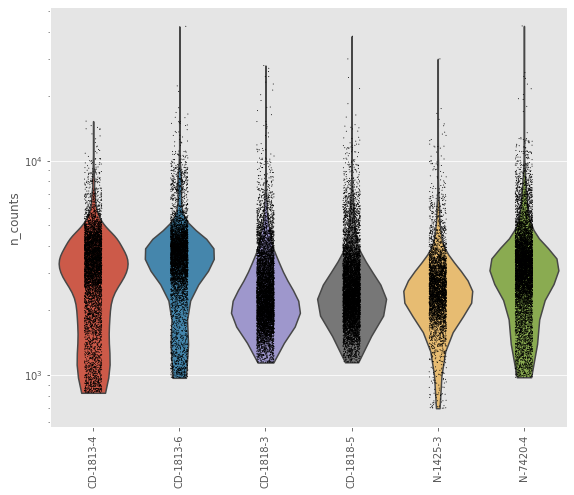

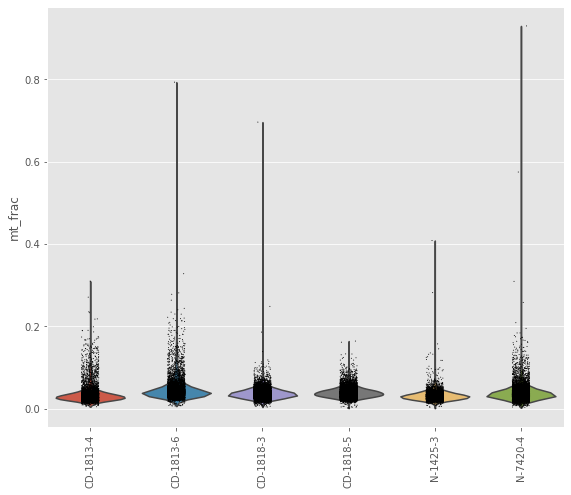

In [22]:
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=1, log=True,cut=0,rotation=90, figsize=(2,2))
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample',rotation=90)

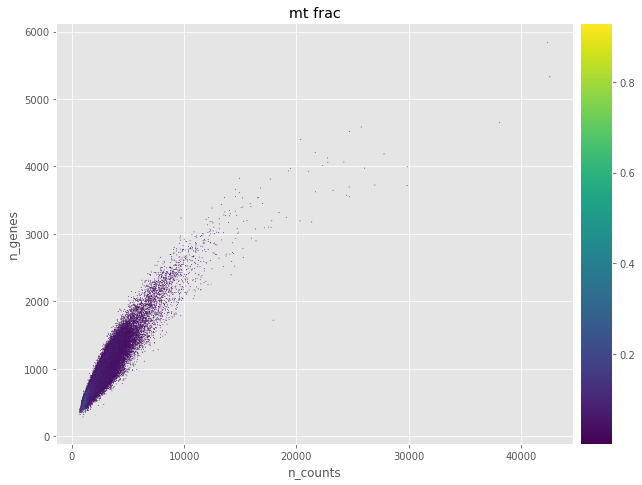

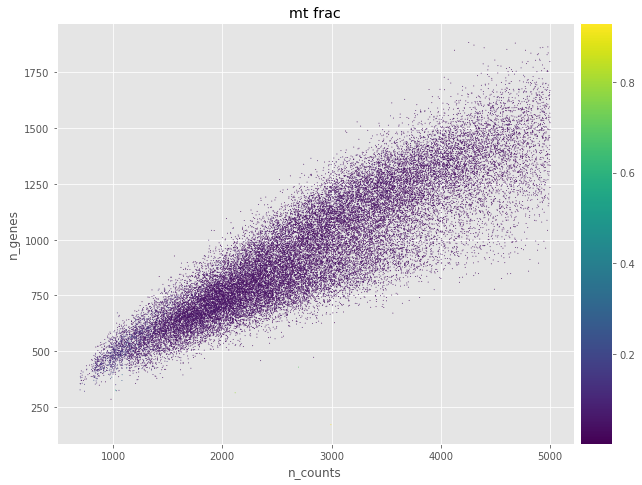

In [23]:
# ncount and ngenes summary, you can change the axis region to zoom in
p1 = sc.pl.scatter(adata,'n_counts','n_genes',color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<5000],'n_counts','n_genes',color='mt_frac')

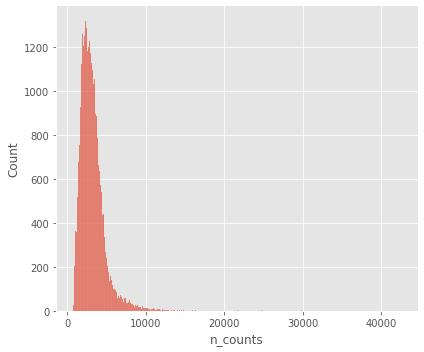

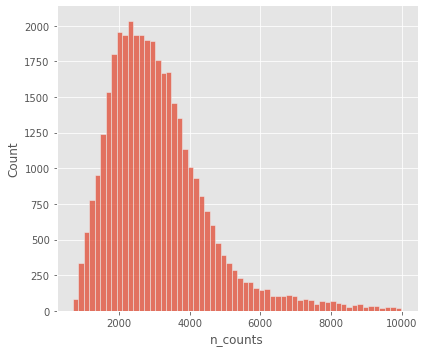

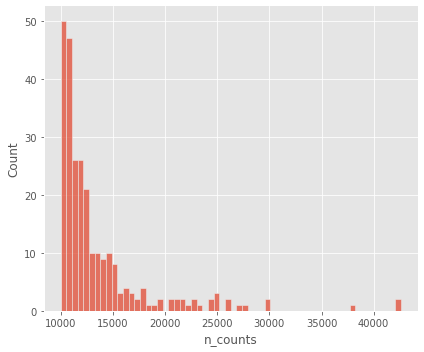

In [24]:
#Thresholding decision: counts, use height and aspect to change figure size
p3 = sb.displot(adata.obs['n_counts'], kde=False,height=5, aspect=1.2)
p4 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']<10000], kde=False, bins=60,height=5,aspect=1.2)
p5 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60,height=5,aspect=1.2)

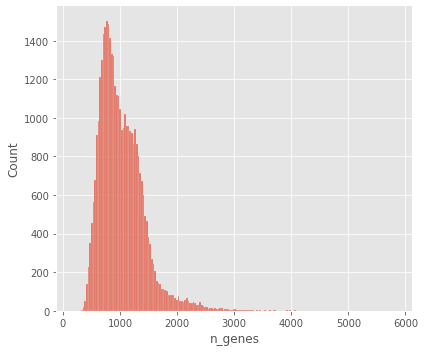

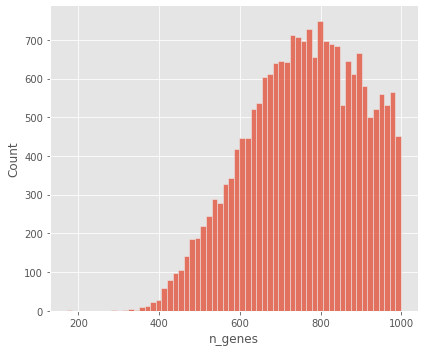

In [25]:
#Thresholding decision: genes
p5 = sb.displot(adata.obs['n_genes'], kde=False,height=5, aspect=1.2)
p6 = sb.displot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60,height=5,aspect=1.2)

From the above QC plots, you can determine the threshold for filtering n_genes, n_counts, mt_fraction

In [26]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 25000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 38209
filtered out 386 cells that have less than 1000 counts
Number of cells after min count filter: 37823
filtered out 9 cells that have more than 25000 counts
Number of cells after max count filter: 37814
Number of cells after MT filter: 37786
filtered out 17 cells that have less than 400 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 37769


## 2.2 Normalization
This step creates a copy of adata and run clustering to generate a pre-clusters which will be used for downstream normalization

In [27]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:25)
computing neighbors
    using 'X_pca' with n_pcs = 15


2022-09-12 22:34:32.544818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:/hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64/lib:/.singularity.d/libs
2022-09-12 22:34:32.548765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:04)


In [28]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [29]:
#Delete adata_pp
del adata_pp

Calculating size factors using scrun is memory intensive, and also takes a lot of time. Eg: if your data has 60k cells, it would take about a little over 70 GB memory.

In [30]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

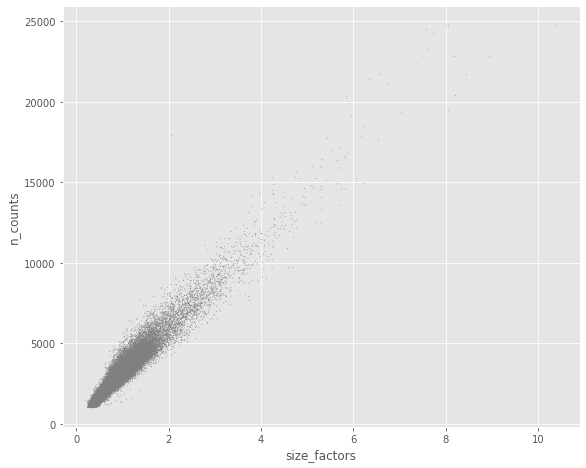

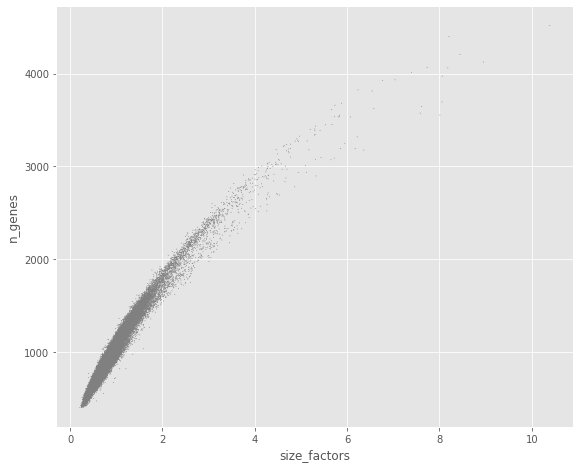

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


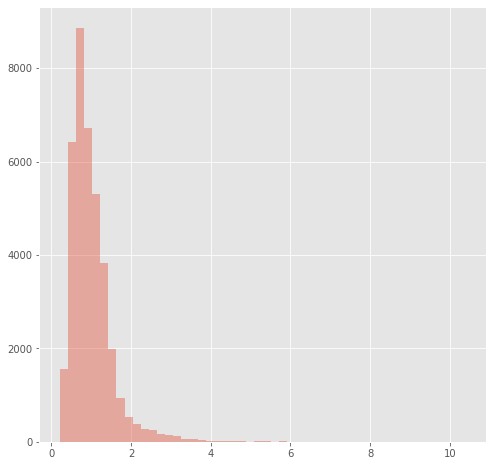

In [31]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [32]:
# Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [33]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [34]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 2.3 Batch correction
Performed using combat, usually correct based on sample. 
There are some other popular batch correction method like BBKNN tutorial or ingest here for integrating datasets.https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html <br/> 

Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction.

In [35]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')
adata.X[adata.X < 0] = 0
# adata.X[adata.X == np.inf] = 0

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Found 10496 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



## 2.4 Highly Variable Genes
Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these. <br/>

Note: raw code of scanpy may get error if the bin edges are duplicated. The error message is ** Bin edges must be unique, You can drop duplicate edges by setting the 'duplicates' kwarg**. To makesure the error would not occur for all cases, you can change the source code in line 244 of the file https://github.com/scverse/scanpy/blob/master/scanpy/preprocessing/_highly_variable_genes.py#L295-L564.  add a parameter duplicates='drop'

In [36]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000,n_bins=50)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


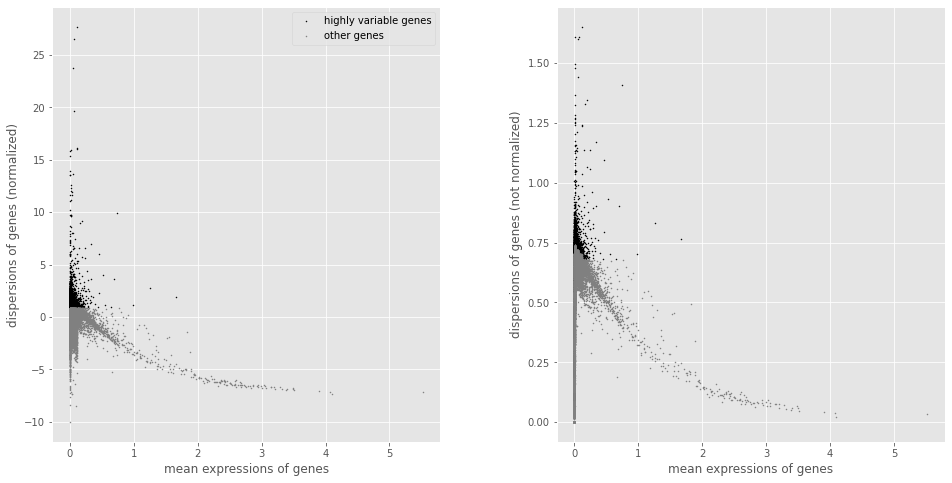

In [37]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- batch corrected data in adata.X
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

## 2.5 Visualization
Plot PCA, t-SNE, u-map, diffusion map

In [38]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/opt/python/lib/python3.8/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
/opt/python/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.97946835 0.9460282  0.94104356 0.9241599  0.91613466
     0.9063216  0.8993163  0.8987198  0.89178616 0.8861224  0.8743554
     0.8737721  0.87309897 0.8668352 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:05:23)


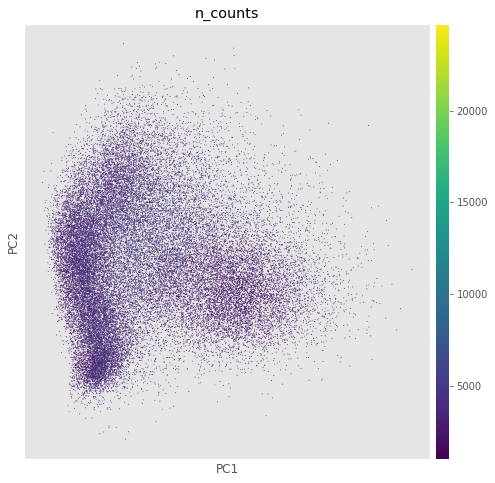

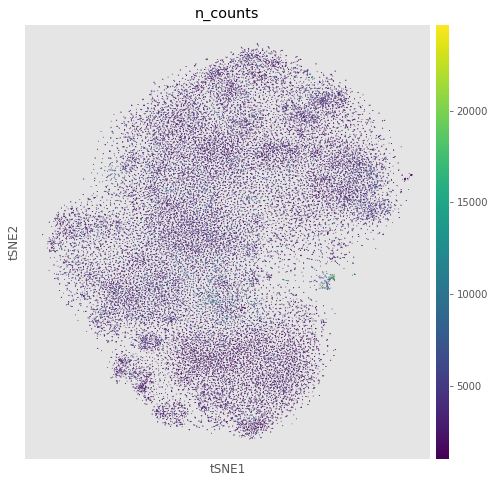

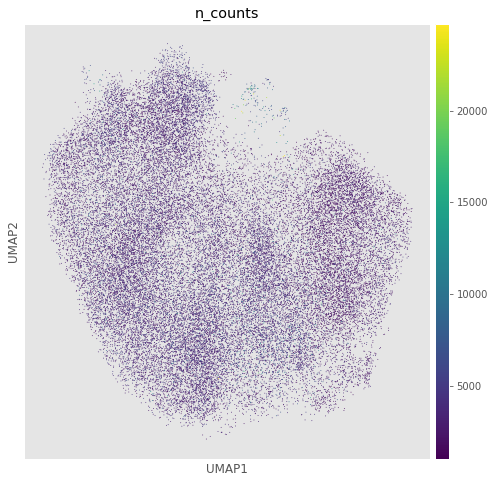

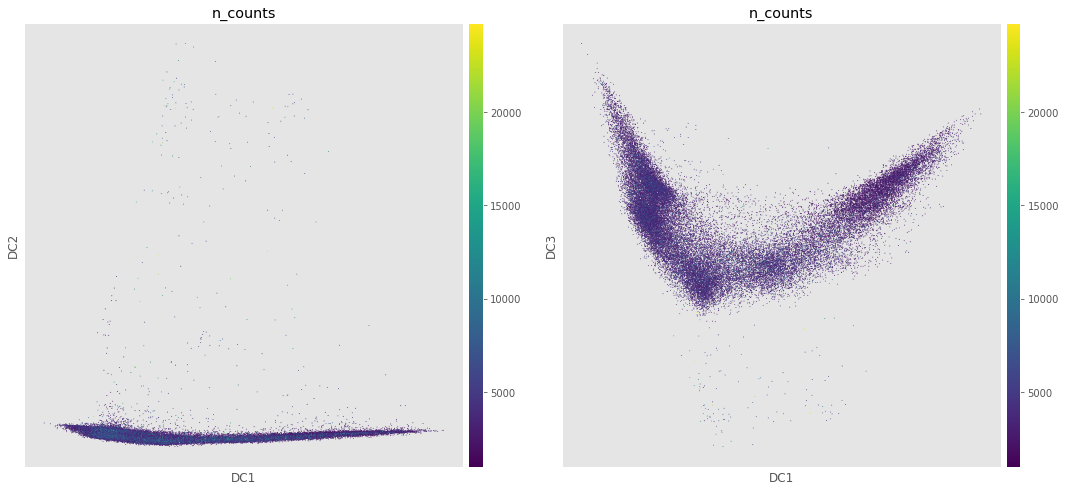

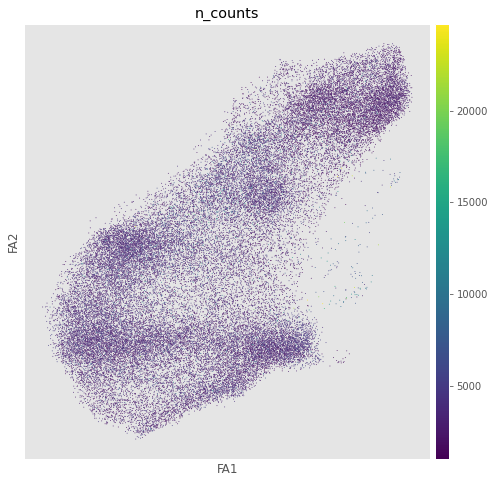

In [39]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

## 2.6 Cell cycle scoring
Annotate cell state in cell cycle. States are S, G2.M, 

In [40]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    1 total control genes are used. (0:00:04)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2 total control genes are used. (0:00:04)
-->     'phase', cell cycle phase (adata.obs)


# 3. Downstream analysis
## 3.1 Clustering
First calculate PCA, then use the PCA to get K nearest neighbor, and then use louvian method to do clustering.
You can set random_state to make sure the results is reproducible.

In [41]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:04)


In [42]:
adata.obs['louvain_r0.5'].value_counts()

0    11861
1     9418
2     8868
3     7456
4      166
Name: louvain_r0.5, dtype: int64

... storing 'phase' as categorical


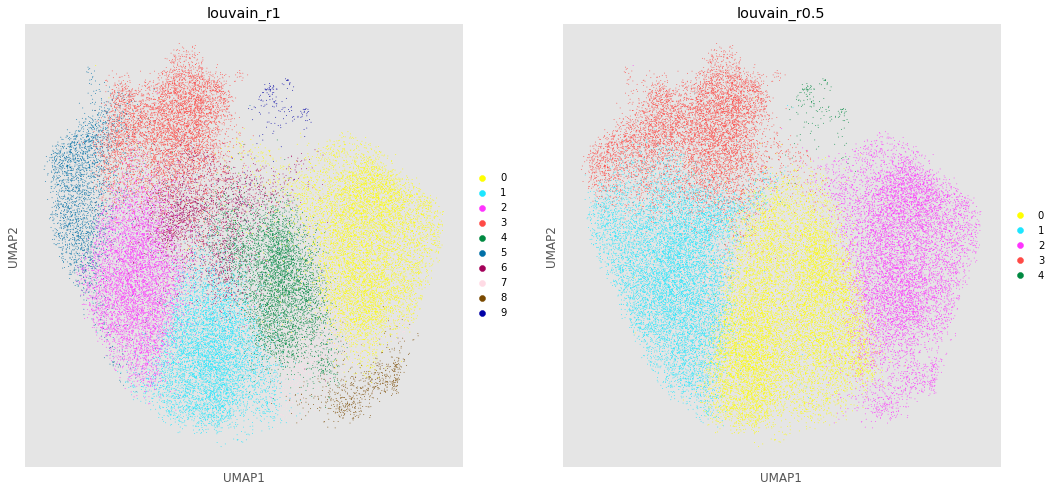

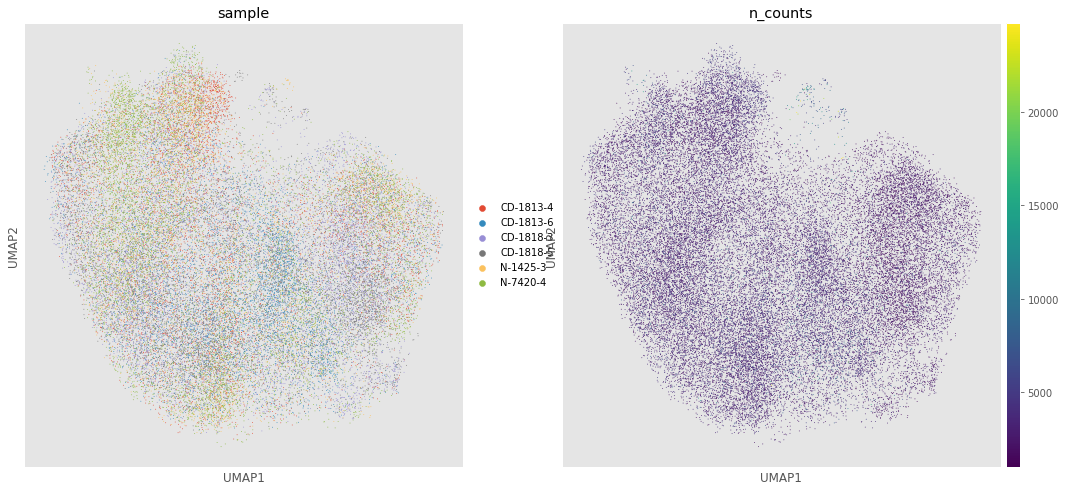

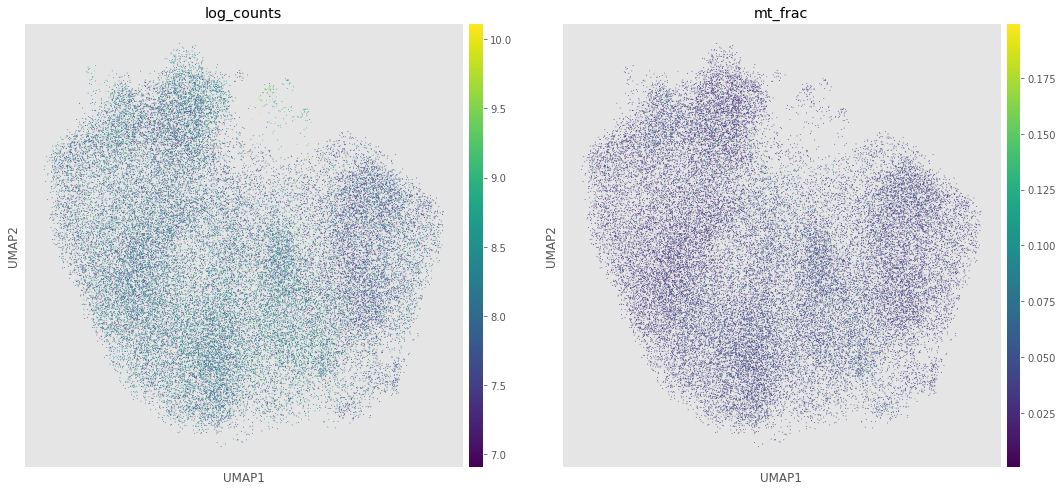

In [43]:
# Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_102)
sc.pl.umap(adata, color=['sample', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

## 3.2 Marker genes & cluster annotation
This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

In [44]:
# Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)
ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:06)


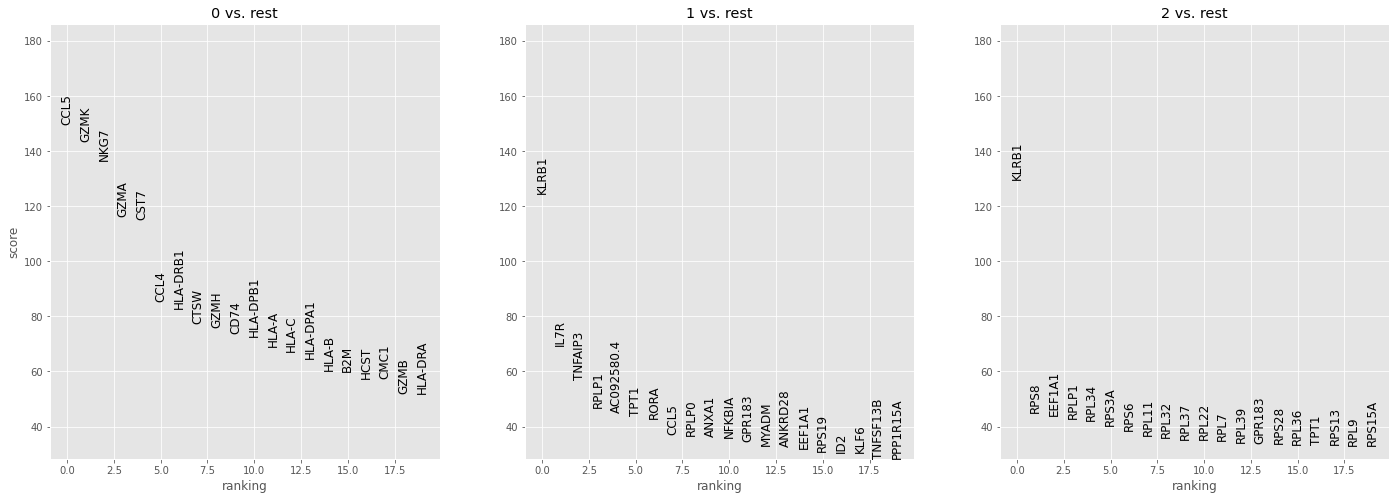

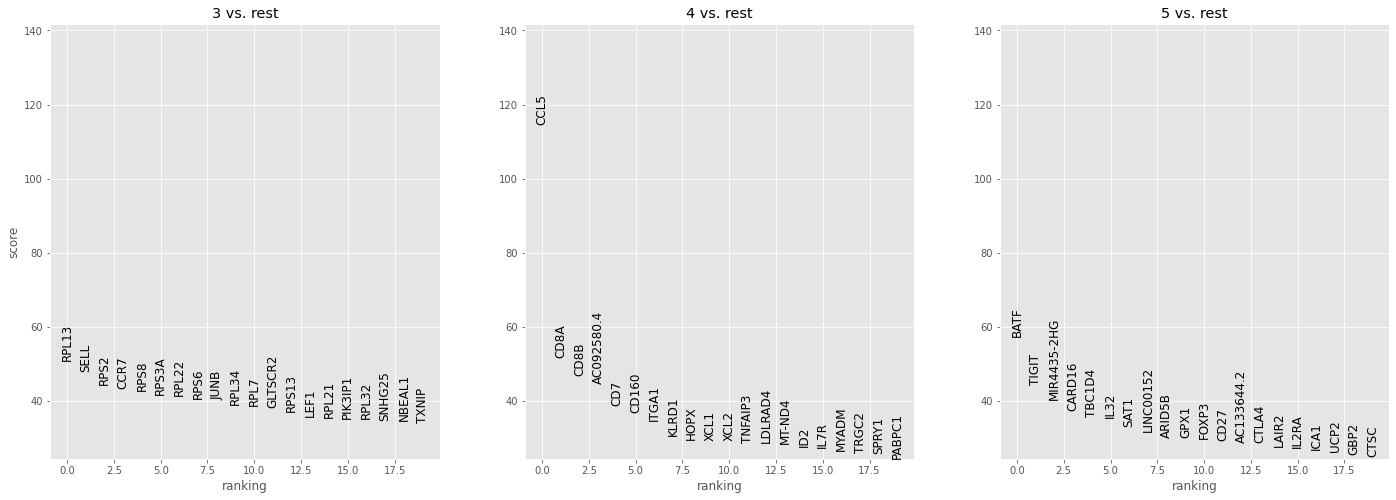

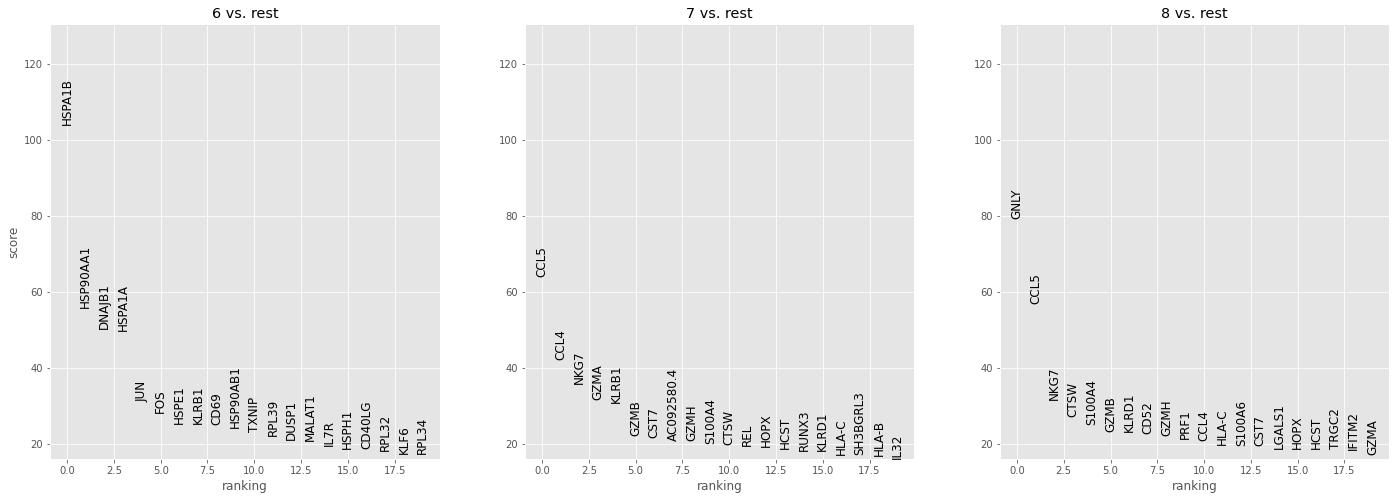

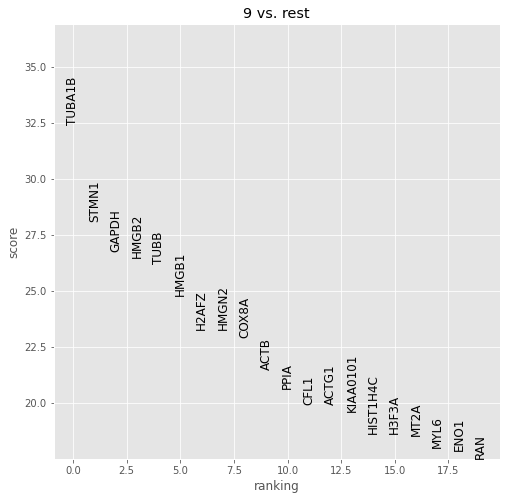

In [45]:
#Plot marker genes, need to change groups based on how many clusters you get
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['6','7','8'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['9'], fontsize=12)

### 3.2.1 Annotate using SCSA
Tools is available here https://github.com/bioinfo-ibms-pumc/SCSA.

In [46]:
# 1. format files
result = adata.uns['rank_genes_r1']
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
cluster_fn = f'{work_dir}/scanpy_cluster1.txt'
dat.to_csv(cluster_fn)

In [47]:
# need to change some parameters
species = 'Human'
scsa_anno_fn = f'{work_dir}/scanpy_scsa_anno.txt'
cell_anno_db_fn = '/opt/SCSA/whole.db'
cmd = f'python /opt/SCSA/SCSA.py -d {cell_anno_db_fn} -i {cluster_fn} -s scanpy -E -f1.5 \
       -p 0.01 -o {scsa_anno_fn} -m txt -g {species}'
os.system(cmd)

Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='/opt/SCSA/whole.db', foldchange=1.5, input='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/public/crohn_LPL/scanpy_cluster1.txt', list_tissue=False, noprint=False, norefdb=False, outfmt='txt', output='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/public/crohn_LPL/scanpy_scsa_anno.txt', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='All', weight=100.0)
Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
load markers: 45409
############################## Cluster 0 ##############################

Cell Num: 131
Gene Num: 120
Not Zero: 475
Cluster 0 Gene number: 157
------------------------------------------------------------
Type                Cell Type           Score     Times
------------------------------------------------------------
?              Natural killer cell      6

0

In [48]:
# read in marker file from cell marker
cell_mk_fn = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/markers/cellMarkers.tsv'
cell_mk_df = pd.read_csv(cell_mk_fn,sep='\t',header=0)

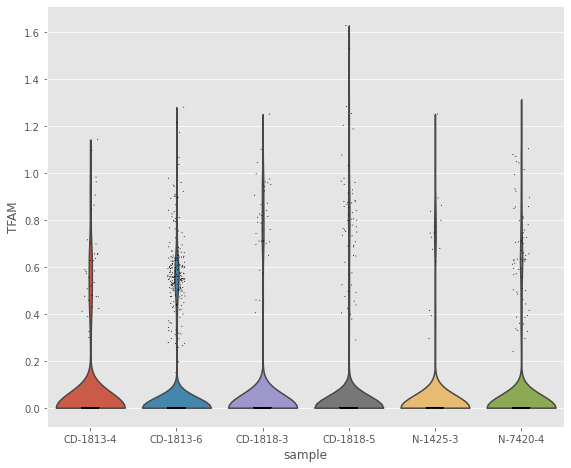

<Figure size 576x576 with 0 Axes>

In [49]:
# for i in range(10):
cd8_adata = adata[adata.obs['louvain_r1'] == '4']
ax = sc.pl.violin(cd8_adata, 'TFAM', groupby='sample')
plt.savefig(f'{work_dir}/cluster.png')

In [50]:
adata.obs['louvain_r0.5'] == '1'

AAACCTGAGCCAGAAC    False
AAACCTGAGCGATCCC    False
AAACCTGAGGCAATTA     True
AAACCTGAGGCTCATT    False
AAACCTGCAGCCTGTG    False
                    ...  
TTTGTCAGTGATGTGG    False
TTTGTCATCCATGAAC    False
TTTGTCATCCCATTAT    False
TTTGTCATCCGAATGT     True
TTTGTCATCTTGCCGT     True
Name: louvain_r0.5, Length: 37769, dtype: bool

In [51]:
cell_mk_df.head()

speciesType          tissueType     cellType  \
0       Human              Kidney  Normal cell   
1       Human               Liver  Normal cell   
2       Human         Endometrium  Normal cell   
3       Human                Germ  Normal cell   
4       Human  Corneal epithelium  Normal cell   

                           cellName CellOntologyID     gene        ensemblID  \
0             Proximal tubular cell            NaN     ALPI  ENSG00000163295   
1  Ito cell (hepatic stellate cell)     CL_0000632      SYP  ENSG00000102003   
2                  Trophoblast cell     CL_0000351  CEACAM1  ENSG00000079385   
3              Primordial germ cell     CL_0000670     DDX4  ENSG00000152670   
4                   Epithelial cell     CL_0000066     KLF6  ENSG00000067082   

  markerResource      PMID  weight  
0     Experiment   9263997       1  
1     Experiment  10595912       1  
2     Experiment  10751340       1  
3     Experiment  10920202       1  
4     Experiment  12407152       1

In [52]:
print(cell_mk_df['cellName'].unique().tolist())

['Proximal tubular cell', 'Ito cell (hepatic stellate cell)', 'Trophoblast cell', 'Primordial germ cell', 'Epithelial cell', 'Cytotrophoblast', 'Periosteum-derived progenitor cell', 'Amnion epithelial cell', 'Primitive streak cell', 'Stromal vascular fraction cell', 'Bulge stem cell', 'Semilunar valve cell', 'Villous stromal cell', 'Kupffer cell', 'Adipose-derived stromal cell', 'Oligodendrocyte', 'Mesenchymal stem cell', 'Cartilage progenitor cell', 'Osteocyte', 'Osteoclast', 'Bipolar cell', 'Muller cell', 'Monocyte', 'Natural killer cell', 'Cancer stem cell', 'Endometrial stem cell', 'Dental pulp stem cell', 'B cell', 'Adipose-derived stem cell', 'Preadipocyte progenitor cell', 'Regulatory T (Treg) cell', 'Nucleus pulposus cell', 'Urine-derived stem cell', 'Fibroblast', 'Immune cell', 'Endothelial cell', 'T cell', 'Thymocyte', 'Dendritic cell', 'Neutrophil', 'Lymphocyte', 'Endothelial progenitor cell', 'Tumor endothelial cell', 'Premeiotic germ cell', 'Gonocyte', 'Mesenchymal stromal

In [53]:
adata.write_h5ad('/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/public/crohn/adata.h5ad')

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/public/crohn/adata.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)